# Water Quality, Perception and Knowledge in China
## Master's thesis data for Tsinghua University

This document is the data analysis of water quality, water quality perception, and water quality knowledge in China. The analysis is driven primarily by two datasets - water quality (2017, per prefecture) and a national general social survey (China General Social Survey, 2010) with an environmental module.

Several questions are examined:
- How do peoples perception of water quality (importance, status, severity, their knowledge, etc) align with actual water quality?
- Is there a correlation between water quality and perception of water quality? (I.e. do perceptions and reality match)?
- Does knowledge of water quality affect perception? 
- Does general education affect perception?

This document show the progression of analysis, thus not all cells and text are relevant to the final findings of this thesis.

<div class="alert alert-block alert-info">
<b>Note:</b> Work in progress (Jan 31, 2021).</div>

---

## Table of Contents

[Load Data](#Load-Data)  
[Initial Data Exploration](#Initial-Data-Exploration)  
[Combining Data](#Combining-Data)  
[Individual Data Analysis](#Individual-Data-Analysis)

---

## Load Data

In [68]:
import pandas as pd
from pandas import DataFrame
import matplotlib as mpl
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.multivariate.manova import MANOVA
import sklearn
from sklearn import preprocessing

In [69]:
# Returns ALL columns when displaying DataFrame, useful for finding column names
pd.set_option('display.max_columns', None)

### 1. China General Social Survey (2010)

The first dataset is the China General Social Survey (CGSS), an annual national comprehensive survey consisting of demographic data, social indicators, and rotating modules. The year 2010 is used since it is the latest published which includes the environmental module, 20+ questions about quality of the environment, peoples' thoughts on the importance of the environment, the severity of environmental degredation, etc. (more details below).

http://cgss.ruc.edu.cn/index.php?r=index/index&hl=en

In [111]:
# Load cgss2010 Stata file, display the first 5 rows (.head())
cgss = pd.read_stata('../data/cgss2010_12.dta', convert_categoricals=False)

#### General Demographics
s41 - province codes

a2 - gender

a3a - birth year

a3b - birth month

a3c - birth date

a7a - highest current level of education

a8a - personal total income

a15 - subjective physical health

a62 - family total income (2009)

a91 - rural / agricultural household *(1=yes, 2=no)*

a92 - rural / agricultural household *(1=yes, 2=no) (verified by surveyor)*


#### Environmental Module (Part L)
l1a - "In your opinion, in terms of the current situation in our country, which of the following issues is the most important?" **(4 = environment)**

l1b - *like l1a, but 2nd most important*

l6a - "In your opinion, in terms of the current situation in our country, which of the following issues is the most important?" *(1 = not at all, 5 = very concerned)*

l6b - How serious are env. problems facing China? *(1 = very, 5 = not at all)*

l7a - Which is most important env. issue in China? **(4 = water pollution)**

l7b - Which has greatest impact on you/family? **(4 = water pollution)**

l8a - Knowledge of causes of environmental problems from ?l7

l8b - Knowledge of solutions of environmental problems from ?l7

l12a - "In order to protect the environment, to what extent are you willing to pay a higher price?" *(1 = very willing, 5 = very reluctant)*

l12b - *like l12a, but with higher taxes*

l12c - like l12a/b, but with willingness to lower living standards

l137 - "Environmental issues directly affect my daily life" *(1 = disagree, 5 = agree)*

l14d - "How do you think the pollution of rivers, rivers and lakes in China is harmful to the environment?" *(1 = extremely, 5 = not at all)*

l15a/b - *see question, about statements of responsibility for environmental protection (individuals/companies, government, etc.)*

l16c - "In terms of solving environmental problems in your area, how do you think the local government has done in the past five years?" *(1 = ignored, 5 = successful)*

l20e - "Do you often save water or reuse water specifically for environmental protection?" *(1 = always, 4 = never)*

l2409 - "In the domestic water pollution report, the water quality of Category V (5) is better than that of Category I (1)" *(1 = correct, 2 = incorrect, 8 = cannot choose)*


In [112]:
important_questions = ['score','s41','a2','a3a','a3b','a3c','a7a','a8a','a15','a62','a91','a92','l1a','l1b','l6a','l7a','l7b','l8a','l8b','l12a','l12b','l12c','l137','l14d','l15a','l15b','l16c','l20e','l2409']

Below is a subset of only important questions from the environmental module (including and omitting`s41`)

In [113]:
environment = ['s41','l1a','l1b','l6a','l7a','l7b','l8a','l8b','l12a','l12b','l12c','l137','l14d','l15a','l15b','l16c','l20e','l2409']

In [114]:
part_l = ['l1a','l1b','l6a','l7a','l7b','l8a','l8b','l12a','l12b','l12c','l137','l14d','l15a','l15b','l16c','l20e','l2409']

*For some reason, I need to manually copy the list of important column codes. They are the same as the `important questions` above.*

In [115]:
cgss_important = cgss[['s41','a2','a3a','a3b','a3c','a7a','a8a','a15','a62','a91','a92','l1a','l1b','l6a','l7a','l7b','l8a','l8b','l12a','l12b','l12c','l137','l14d','l15a','l15b','l16c','l20e','l2409']]
cgss_important.describe()

,s41,a2,a3a,a3b,a3c,a7a,a8a,a15,a62,a91,a92,l1a,l1b,l6a,l7a,l7b,l8a,l8b,l12a,l12b,l12c,l137,l14d,l15a,l15b,l16c,l20e,l2409
count,11783.000000,11783.000000,11783.000000,11783.000000,11783.000000,11783.000000,11783.000,11783.000000,11783.00,11782.000000,6694.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000
mean,15.366205,1.518204,1962.196809,6.590512,14.806331,4.840703,1395715.625,3.606891,1266528.50,1.565948,1.898267,9.581155,10.884532,3.720316,14.029956,13.319989,2.920752,2.583333,3.280229,3.543028,3.572440,3.820534,2.913943,3.227669,3.192810,3.463780,2.482026,6.352397
std,8.865554,0.499690,35.062692,3.472828,8.585052,2.998698,3442447.500,1.139152,3271839.25,0.504143,0.396405,23.114167,25.581364,1.133402,29.785397,28.256381,1.539628,1.583291,1.863691,1.877130,1.766908,1.606539,1.994326,2.708164,2.632461,2.159607,1.031619,2.881289
min,1.000000,1.000000,-3.000000,-3.000000,-3.000000,-3.000000,0.000,-3.000000,0.00,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000
25%,7.000000,1.000000,1952.000000,3.000000,8.000000,3.000000,4000.000,3.000000,15000.00,1.000000,2.000000,1.000000,1.000000,3.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,15.000000,2.000000,1964.000000,7.000000,15.000000,4.000000,12000.000,4.000000,30000.00,2.000000,2.000000,2.000000,2.000000,4.000000,4.000000,4.000000,3.000000,2.000000,3.000000,3.000000,4.000000,4.000000,2.000000,2.000000,2.000000,3.000000,3.000000,8.000000
75%,22.000000,2.000000,1974.000000,10.000000,22.000000,6.000000,30000.000,4.000000,61104.00,2.000000,2.000000,6.000000,6.000000,4.000000,6.000000,6.000000,4.000000,3.000000,4.000000,4.000000,4.000000,5.000000,3.000000,2.000000,2.000000,4.000000,3.000000,8.000000
max,31.000000,2.000000,1993.000000,12.000000,31.000000,14.000000,9999999.000,5.000000,9999999.00,2.000000,2.000000,98.000000,98.000000,8.000000,98.000000,98.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,4.000000,8.000000


#### Very Limited Subset of Questions (for initial analysis)

This only includes the most important questions,

In [76]:
columns_strict = ['s41','l14d','l2409']

In [77]:
cgss_strict = cgss[columns_strict]

Only include the strict set of 3 columns

The survey uses geographic identifiers in columns s41 (and I think s42-44). However, only province level information is released, due to privacy concerns (see [this link](http://cgss.ruc.edu.cn/index.php?r=index/artabout&aid=18)). They are listed below, in a dictionary (Chinese)

In [116]:
provinces = pd.read_csv('prov.csv')
provinces.set_index('s41')

,province_full,province,province_en
s41,,,
1,上海市,上海,Shanghai
2,云南省,云南,Yunnan
3,内蒙古自治区,内蒙古,Inner Mongolia
4,北京市,北京,Beijing
5,吉林省,吉林,Jilin
6,四川省,四川,Sichuan
7,天津市,天津,Tianjin
8,宁夏回族自治区,宁夏,Ningxia
9,安徽省,安徽,Anhui


---

### 2. 2018 Blue City Water Quality Index Ranking

The second dataset is the water quality of every prefecture (sub-province) from a 2018 publication (using 2017 measurements). **Add more details**

https://wwwoa.ipe.org.cn//Upload/201909201147459274.pdf (en)

In [79]:
wqir = pd.read_csv('../data/wqir2018_zh.csv', sep=' ', encoding = "UTF-8")

In [80]:
province = wqir['province']
score = wqir['score']
city = wqir['city']
category = wqir['level']

---

## Initial Data Exploration

### CGSS2010

#### Heatmap Function

The following function asks the user to imput a column title (question code). Any column name can be entered, but for interesting results, choose one from the above list of important survey questions.

Once the column name is entered, the function displays a visual heatmap of the response types by decimal (total = 1.0) on the x axis, sorted by province on the y axis.

Enter `heatmap()` to execute this function.

In [81]:
def heatmap():
    user_column = input('Enter a column code: ')
    user = cgss[cgss[user_column] >= 1]
    # Group by provence, count people in each province, then sort them by asceding order.
    user_grouped = (user.groupby(['s41', user_column])
        .size()
        .unstack(fill_value=0)
        .sort_index(axis=1, ascending=True)
        )
    user_grouped_percent=user_grouped.div(user.groupby(['s41']).size(), axis=0)
    user_grouped_percent=user_grouped_percent.round(1)
    fig, ax = plt.subplots()
    sns.set_theme(
        style="white",
        font='AR PL UMing CN',
        font_scale=.30,
        )
    sns.heatmap(
        user_grouped_percent,
        vmin=0,
        vmax=1,
        yticklabels=1,
        annot=True,
        cmap='viridis',
        square=True,
        cbar=False,
        )
    ax.set_title(user_column)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="center", rotation_mode="anchor")
    fig.tight_layout()

#### Count Function

The following function does the same initial steps as the `heatmap` function, but without normalizing by the number of responses per province (it only sums the responses by type and by province).

Enter `count()` to execute this function.

In [82]:
def count():
    user_column = input('Enter a column code: ')
    user = cgss[cgss[user_column] >= 1]
    user_grouped = (user.groupby(['s41', user_column])
        .size()
        .unstack(fill_value=0)
        .sort_index(axis=1, ascending=True)
        )
    return user_grouped

#### Percent Function

The following function is the same as the `count` function, but also normalizes per province to make quanities comparable. It's essentially the `heatmap` function without the visualization.

Enter `percent()` to execute this function.

In [83]:
def percent():
    user_column = input('Enter a column code: ')
    user = cgss[cgss[user_column] >= 1]
    user_grouped = (user.groupby(['s41', user_column])
        .size()
        .unstack(fill_value=0)
        .sort_index(axis=1, ascending=True)
        )
    user_grouped_percent=user_grouped.div(user.groupby(['s41']).size(), axis=0)
    user_grouped_percent=user_grouped_percent
    user_grouped_percent=user_grouped_percent
    return user_grouped_percent

#### Individual Question Countplot

The following function visualizes number of responses (total, not per province) for each response type of an entered column (question code).

Enter `countplot()` to execute this function.

In [84]:
def countplot():
    user_column = input('Enter a column code: ')
    sns.countplot(
        data=cgss,
        x=cgss[user_column],
        )

---

### 2018 Blue City Water Quality Index Ranking Visualization (WQIR2018)

The following shows statististical information for the WQIR2018 dataset. Let's see the data, loaded above. As evident, the `Province`, `City`, `Score`, `Rank`, and the `Level` for the water quality level.

*Run `wqir.head()` to see the shape of the dataframe*

On page 5 of the report [here](https://wwwoa.ipe.org.cn//Upload/201909201147459274.pdf) (mentioned above), the following are the score/level to water quality classes (outlined [here](http://english.mee.gov.cn/SOE/soechina1997/water/standard.htm)):

| IPE Score     | IPE Level (EN)          | IPE Level (ZH) | EQ  Water |
|:-------------:|:-----------------------:|:--------------:|:---------:|
| 0.00 - 4.79   | Excellent               | 优             | II     |
| 4.79 - 10.28  | Good                    | 良             |III    |
| 10.28 - 16.85 | Moderate                | 一般           | IV     |
| 16.85 - 24.74 | Relatively Poor         | 较差           | V       |
| 24.70 - 50.00 | Poor                    | 差             | V      |

*Note: The EQ equivalents above refer "The total score (equivalent to the local water
quality average) met or surpassed the requirements of Class `X` (II-V) water quality..."*

In [117]:
wqir_mean = wqir.groupby(by='province').agg('mean')

The following plot visualizes the WQIR2018 values by province (y axis), with each prefecture's score lined up on the x axis. This is to visualize the range of water quality values in each province. On the top and right, two histograms count the occurances at each value (horizontal, top one bins water quality scores, while the vertical, right one bins the number of prefecture regions per province).

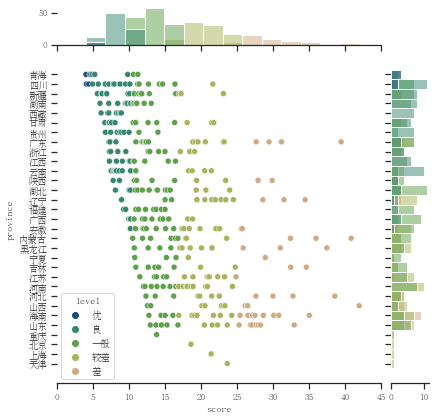

In [87]:
sns.set_theme(
    style="ticks",
    font='AR PL UMing CN',
    font_scale=.85,
    )

g = sns.JointGrid(
    ratio=7,
    space=.25,
    marginal_ticks=True,
    xlim=(0,45),
    x=score,
    y=province,
    palette="gist_earth",
    hue=category,
    data=wqir,
) 
  
sns.despine(trim=False, left=True, bottom=False)
g.plot(sns.scatterplot, sns.histplot)

The provinces of 青海 (Qinghai), 海南 (Hainan), and 西藏 (Tibet) have good water quality which is relatively uniform. These make for good comparison with provinces with worse water quality.

---

## Combining Data

In this section, I will try to link the data from CGSS2010 and WQIR2018 and compare them across provinces.

## Sorting Data

This section has the data loaded previously sorted, usually by province.

First, count the values of the `cgss_strict` df (so it's easier to deal with and understand) by province `s41`. I learned this [here](https://kanoki.org/2020/03/09/how-to-use-pandas-count-and-value_counts/).

*Run `cgss_strict.groupby(by='s41').agg('count')` to see the number of responses per province*

### `l14d`

Sort by response types for `l14d`, see the number of responses. Column `s41` is irrelavent, this is just to see all response types for `l14d` to check for incorrect values.

Call one column `l14d`, then count instances of values with `.value_counts()`, then make a dataframe with `.to_frame()`, then sort by the response value with `.sort_index()`

In [118]:
cgss_strict['l14d'].value_counts().to_frame().sort_index()

,l14d
-3.0,6
-2.0,11
1.0,565
2.0,1429
3.0,972
4.0,250
5.0,37
8.0,402


As we can see, there are negative values, which are not valid response types. Let's see which provinces they're in, to see if we can safely drop the values.

In [90]:
cgss_strict[cgss_strict['l14d'] < 0].groupby(by='s41').agg('count')

,l14d,l2409
s41,,
1.0,2,2
2.0,3,3
6.0,1,1
7.0,1,1
10.0,1,1
17.0,1,1
19.0,1,1
21.0,2,2
22.0,1,1


### `l2409`

repeat

In [91]:
cgss_strict['l2409'].value_counts().to_frame().sort_index()

,l2409
-3.0,25
-2.0,19
1.0,287
2.0,596
8.0,2745


In [92]:
cgss_strict[cgss_strict['l2409'] < 0].groupby(by='s41').agg('count')

,l14d,l2409
s41,,
1.0,2,2
2.0,3,3
6.0,2,2
7.0,5,5
10.0,1,1
12.0,1,1
15.0,2,2
16.0,1,1
19.0,1,1


---

For the first question `l14d`, the negative values are fairly spread out between columns. It's safe to drop them.


However, for `l2409`, they make up a large proportion of the total response values for province 25, which is Tibet. As seen below, filtered just for Tibet for question l2409, 17/19 responses are invalid. Because water quality for Tibet also isn't included, we're forced to remove it from this analysis.

In [93]:
cgss_strict[cgss_strict['s41']==25].groupby('l2409').agg('count')

,s41,l14d
l2409,,
-3.0,17,17
8.0,2,2


The response value of 8 refers to "cannot choose", so for now, let's drop those (it may be important later)

Let's drop the two problmatic values -3 and -2, and 8, group by province again, and calculate the mean.

## **If I filter out 8, then Ningxia province get's taken out... find a fix**

In [119]:
cgss_strict_mean = cgss_strict.replace([-3,-2,],).groupby(by='s41').agg('mean')

### Merge Data

The following merges the `wqir_mean` values with the `provinces` dataframe.

In [121]:
merge = pd.merge(wqir_mean, provinces, on='province')

Add water quality mean (per province) to each individual row:

Then, the `cgss_strict_clean` values are merged in. (I didn't know how to do this in one step)

In [122]:
merged = pd.merge(merge,cgss_strict_mean,on='s41')

Quick check to see if there are visible trends...

<AxesSubplot:xlabel='score', ylabel='l14d'>

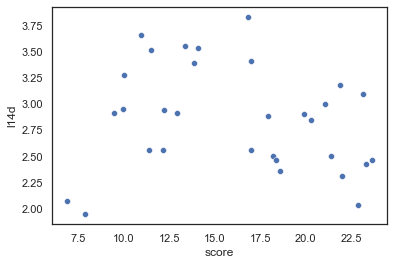

In [123]:
sns.scatterplot(
    x='score',
    y='l14d',
    data=merged,
)

---

Now, let's do this with the larger `cgss_important` dataframe:

*Trying to get a df with values as index and frequency per question (column), but can't...*

In [98]:
cgss_part_l = cgss_important[part_l]
for column in cgss_part_l:
    counts = cgss_part_l[column].value_counts()
    counts.append(counts)

Create the mean of all values from `cgss_important`:

In [99]:
cgss_imp_mean = cgss_important.groupby(by='s41').agg('mean')

Merge with water quality and provinces:

In [124]:
merged_imp = pd.merge(merge,cgss_imp_mean,on='s41')

*Play around with some correlations:*

In [101]:
corr = cgss_important.corr(method="pearson")

In [102]:
corr_mean = merged_imp.corr(method="pearson")

Plot, first set the theme

In [125]:
sns.set_theme(
    style="white",
    font='AR PL UMing CN',
    font_scale=.2,
    )

IndentationError: unexpected indent (<ipython-input-125-e5216f502b65>, line 2)

/home/will/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/will/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


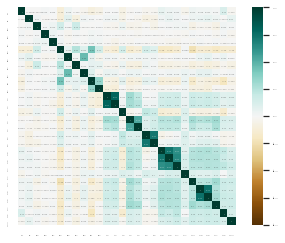

In [104]:
corr_hm = sns.heatmap(
    corr,
    vmin=-1,
    vmax=1,
    annot=True,
    cmap='BrBG',
    square=True,
    cbar=True,
    center=0
    )

In [105]:
figure1 = corr_hm.get_figure()

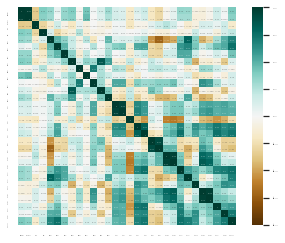

In [106]:
corr_mean_hm = sns.heatmap(
    corr_mean,
    vmin=-1,
    vmax=1,
    center=0,
    annot=True,
    cmap='BrBG',
    square=True,
    cbar=True,
    )

Check quickly for a .37 correlation (haven't filtered out 8 value responses yet)

<AxesSubplot:xlabel='score', ylabel='l14d'>

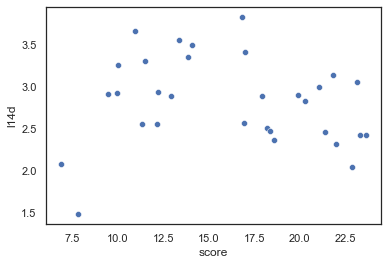

In [107]:
sns.set_theme(
    style="white",
    font_scale=1,
    )
sns.scatterplot(
    x='score',
    y='l14d',
    palette="gist_earth",
    data=merged_imp,
)

---

## Individual Data Analysis

This section adds mean water quality scores per province to each individual response of the `cgss` dataframe, thus analysis with more statistical significance can be done.

First, take only the s41 codes and wq mean scores from the `merge` dataframe, then add the water quality `score` to the main `cgss` dataframe:

In [108]:
wq = merge[['s41','score']]
cgss_wq = pd.merge(cgss,wq,on='s41')

This analysis will first be done on the `important` columns, from above:

In [128]:
cgss_wq_imp = cgss_wq[important_questions]
cgss_wq_imp_clean = cgss_wq_imp.dropna()

Filter out negative values and unknown ('8')

In [132]:
wq_imp_clean = cgss_wq_imp_clean[
    (cgss_wq_imp_clean.l14d > 0) 
     & (cgss_wq_imp_clean.l14d < 6) 
     & (cgss_wq_imp_clean.l2409 > 0) 
     # (cgss_wq_imp_clean.l2409 < 3)
    ]

In [131]:
clean_prov = wq_imp_clean.groupby('s41').agg('mean')

In [133]:
maov = MANOVA.from_formula('l14d + l2409 ~ s41 + score', data=wq_imp_clean)
print(maov.mv_test())

                   Multivariate linear model
                                                               
---------------------------------------------------------------
       Intercept        Value  Num DF   Den DF  F Value  Pr > F
---------------------------------------------------------------
          Wilks' lambda 0.6818 2.0000 1975.0000 460.8016 0.0000
         Pillai's trace 0.3182 2.0000 1975.0000 460.8016 0.0000
 Hotelling-Lawley trace 0.4666 2.0000 1975.0000 460.8016 0.0000
    Roy's greatest root 0.4666 2.0000 1975.0000 460.8016 0.0000
---------------------------------------------------------------
                                                               
---------------------------------------------------------------
           s41           Value  Num DF   Den DF  F Value Pr > F
---------------------------------------------------------------
           Wilks' lambda 0.9985 2.0000 1975.0000  1.4759 0.2288
          Pillai's trace 0.0015 2.0000 1975.0000  1.4759 0.

Conduct OLS regression with l14d dependent on gender, age (year) and income:

In [134]:
ols_perception = smf.ols('l14d ~ score + a2 + a3a + a7a', data = wq_imp_clean).fit()
print(ols_perception.summary())

                            OLS Regression Results                            
Dep. Variable:                   l14d   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     14.85
Date:                Sun, 31 Jan 2021   Prob (F-statistic):           5.83e-12
Time:                        18:06:32   Log-Likelihood:                -2475.7
No. Observations:                1979   AIC:                             4961.
Df Residuals:                    1974   BIC:                             4989.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8522      2.501     -0.341      0.7

*Think of a way to run the ols for knowledge without the l2409 = 8 values*

In [135]:
ols_knowledge = smf.ols('l2409 ~ s41 + score + a2 + a3a + a7a + a91', data = wq_imp_clean).fit()
print(ols_knowledge.summary())

                            OLS Regression Results                            
Dep. Variable:                  l2409   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     12.86
Date:                Sun, 31 Jan 2021   Prob (F-statistic):           2.49e-12
Time:                        18:06:39   Log-Likelihood:                -4853.2
No. Observations:                1979   AIC:                             9718.
Df Residuals:                    1973   BIC:                             9752.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9669      1.666      1.181      0.2

### Initial Findings
With P>|t| ~0.05 or less (0.055), this can be argued that an increased wq score (worse) leads to an decreased number for l14d (perceived to be more harmful)

The higher the education (a7a increases), the l14d number goes down (the perceived severity increases)

(The coef is negative for both, which indicates a negative relation/correlation)

**Keep in `l2409` unsure (8) since it increases observations and therefore statistical power (.02 vs .055)**

Thus: Water quality (score) is correlated with perception (l14d) & education (a7a) is correlated to perception, Also (not shown) education is coorelated with wq knowledge (l2409), but score is not correlated with wq knowledge.

#### Test for divergence
Seeing if there's a correlation between the difference between perception and score, and another variable.

Import main data, groupby and take mean...

In [ ]:
tst = wq_imp_clean[['score','s41','l14d']].groupby('s41').agg('mean')
tst.describe()

Normalize the data (0-1) using code I found [here](https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame): 

In [ ]:
test = tst.apply(lambda x: x/x.max(), axis=0)

Make new column with the difference between the score and perception. Perception number goes up as perceived severity goes down. Score goes up as water quality gets worse. 

Diff increases when the two are more different (positive if poor wq and severe perception, negative if good wq and good perception)

In [ ]:
test['diff'] = test['score'] - test['l14d']
test

Plot difference vs wq score

In [ ]:
sns.relplot(
    data=test,
    x="score",
    y="diff",
    hue='l14d'
    )

In [ ]:
sns.relplot(
    data=clean_prov,
    x='score',
    y='l14d',
    label='s41'
)

Interesting! ^